In [4]:
import os 
import numpy as np

import xarray as xr
import downscale as down

import geopandas as gpd

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from scipy.integrate import dblquad, nquad

import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

# import warnings
# warnings.filterwarnings('ignore')

In [5]:
deg_km = 110

resolution = '3h'

tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')

In [6]:
Veneto = gpd.read_file(os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson'))

In [57]:
def wetfrac(array, thresh):
    return np.size(array[array > thresh])/np.size(array)

In [47]:
DOWN_dir =  os.path.join(tmpa_dir, f'data_tmpa_{resolution}_cut_upscale.nc')

DATA_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','IMERG_Italy_1dy_2000_06_01_2024_02_29_veneto_R1.nc')
DATA = xr.open_dataset(DATA_dir)

lat = DATA['lat']
lon = DATA['lon']
lon2d, lat2d = np.meshgrid(lon, lat)

dx = 0.1
dy = 0.1

DATA = DATA.dropna(dim='time', how='any')
DATA

<xarray.Dataset> Size: 33MB
Dimensions:  (time: 8674, lat: 19, lon: 25)
Coordinates:
  * time     (time) datetime64[ns] 69kB 2000-06-01 2000-06-02 ... 2024-02-29
  * lat      (lat) float64 152B 44.85 44.95 45.05 45.15 ... 46.45 46.55 46.65
  * lon      (lon) float32 100B 10.65 10.75 10.85 10.95 ... 12.85 12.95 13.05
Data variables:
    PRE      (time, lat, lon) float64 33MB 0.0 0.0 0.0 0.0 ... 2.765 3.94 4.5
Attributes:
    description:  IMERG daily data for Italy region

In [48]:
lo_max, lo_min, la_max, la_min = 13.102129, 10.623646, 46.680462, 44.790684

Text(1.0, 1.0, 'Jan-2000 to Feb-2024')

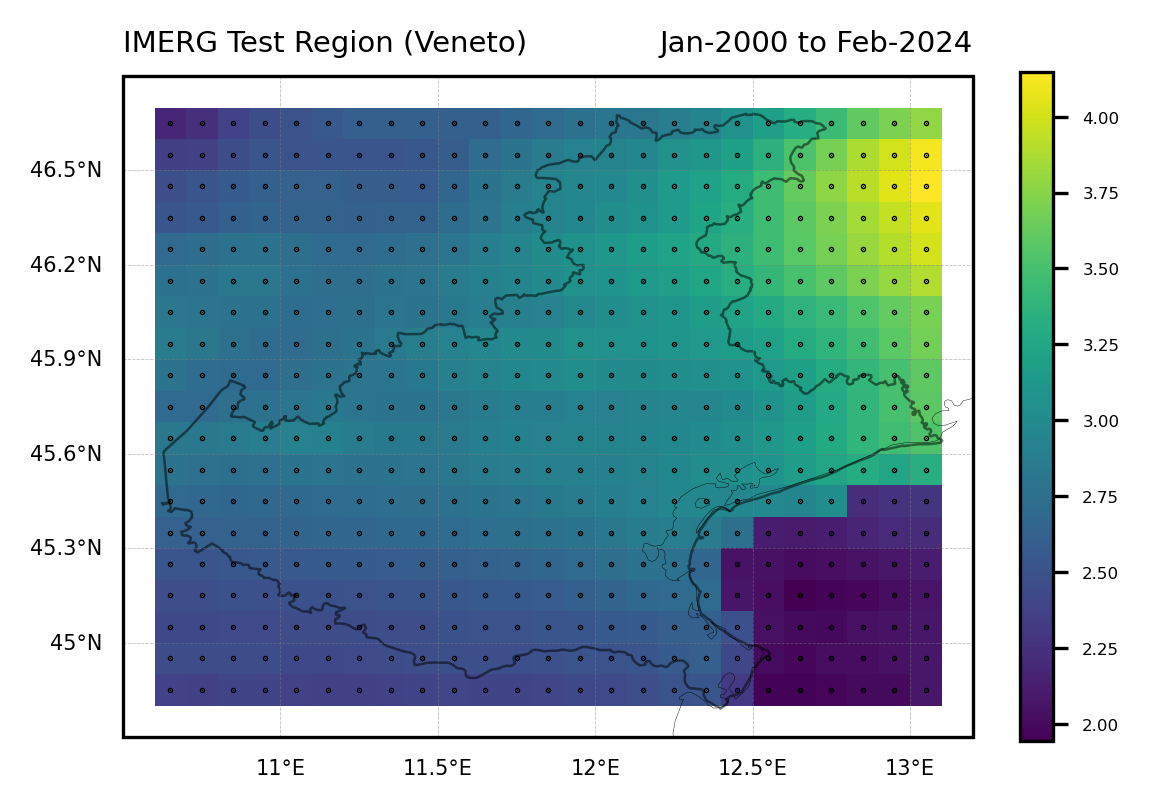

In [55]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
# a1 = ax1.contourf(lon2d, lat2d, np.nanmean(DATA['PRE'],axis=0), cmap=cmap)
a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(DATA['PRE'],axis=0))
# ax1.add_patch(patches.Rectangle((lo_max,la_max),lo_min-lo_max,la_min-la_max,linestyle='--',linewidth=0.9,edgecolor='k',facecolor='None',zorder=10))
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.036)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('IMERG Test Region (Veneto)', fontsize=7, loc='left')
ax1.set_title('Jan-2000 to Feb-2024', fontsize=7, loc='right')

In [10]:
tmpalat = DATA['lat'][:]
tmpalon = DATA['lon'][:]
dates = DATA['time'][:]
dset = np.swapaxes(DATA['PRE'],0,2).data[:,:,:]
DATA = xr.DataArray(dset,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                    dims=('lon', 'lat', 'time'))
xrs = DATA.where(DATA >= -0.001)

In [11]:
lats = xrs.lat.values
lons = xrs.lon.values

nlats = np.size(lats)
nlons = np.size(lons)

nelem = nlats*nlons

lats9 = np.repeat(lats, nlons)
lons9 = np.tile(lons, nlats)

ncorr = (nelem)*(nelem - 1)//2
vcorr = np.zeros(ncorr)
vdist = np.zeros(ncorr)

In [12]:
thresh = 1

In [13]:
count = 0
for i in range(nelem):
    tsi = xrs.loc[dict(lat=lats9[i], lon=lons9[i])].values
    tsi = np.maximum(tsi-thresh, 0.0)
    for j in range(i+1, nelem):
        tsj = xrs.loc[dict(lat=lats9[j], lon=lons9[j])].values
        tsj = np.maximum(tsj-thresh, 0.0)
        vcorr[count] = down.corr(tsi, tsj)
        vdist[count] = down.haversine(lats9[i], lats9[j], lons9[i], lons9[j])
        count = count + 1

res = {}
res['vdist'] = vdist
res['vcorr'] = vcorr

In [14]:
xx = np.linspace(np.min(vdist), np.max(vdist), 20)

In [15]:
# fit curves to observed correlation
popt, pcov = down.curve_fit(down.str_exp_fun, vdist, vcorr, p0=np.array([50, 1]), bounds=(np.array([0.0, 0.0]), np.array([+np.inf, +np.inf])))

res['d0_s'] = popt[0]
res['mu0_s'] = popt[1]

popt1, pcov1 = down.curve_fit(down.epl_fun, vdist, vcorr, p0=np.array([50, 1]), bounds=(np.array([0.0, 0.0]), np.array([+np.inf, +np.inf])))
res['eps_s'] = popt1[0]
res['alp_s'] = popt1[1]

In [16]:
stretched_exp = down.str_exp_fun(xx, res['d0_s'], res['mu0_s'])
exp_power_law = down.epl_fun(xx, res['eps_s'], res['alp_s'])

In [17]:
res

{'vdist': array([ 7.88325569, 15.7665084 , 23.64967995, ...,  7.63296706,
        15.26600384,  7.63303985]),
 'vcorr': array([0.97249021, 0.94372819, 0.90650366, ..., 0.96710214, 0.93698215,
        0.96850867]),
 'd0_s': 194.56596836221885,
 'mu0_s': 0.9596465879404446,
 'eps_s': 188.7039348375136,
 'alp_s': 0.9902309414598595}

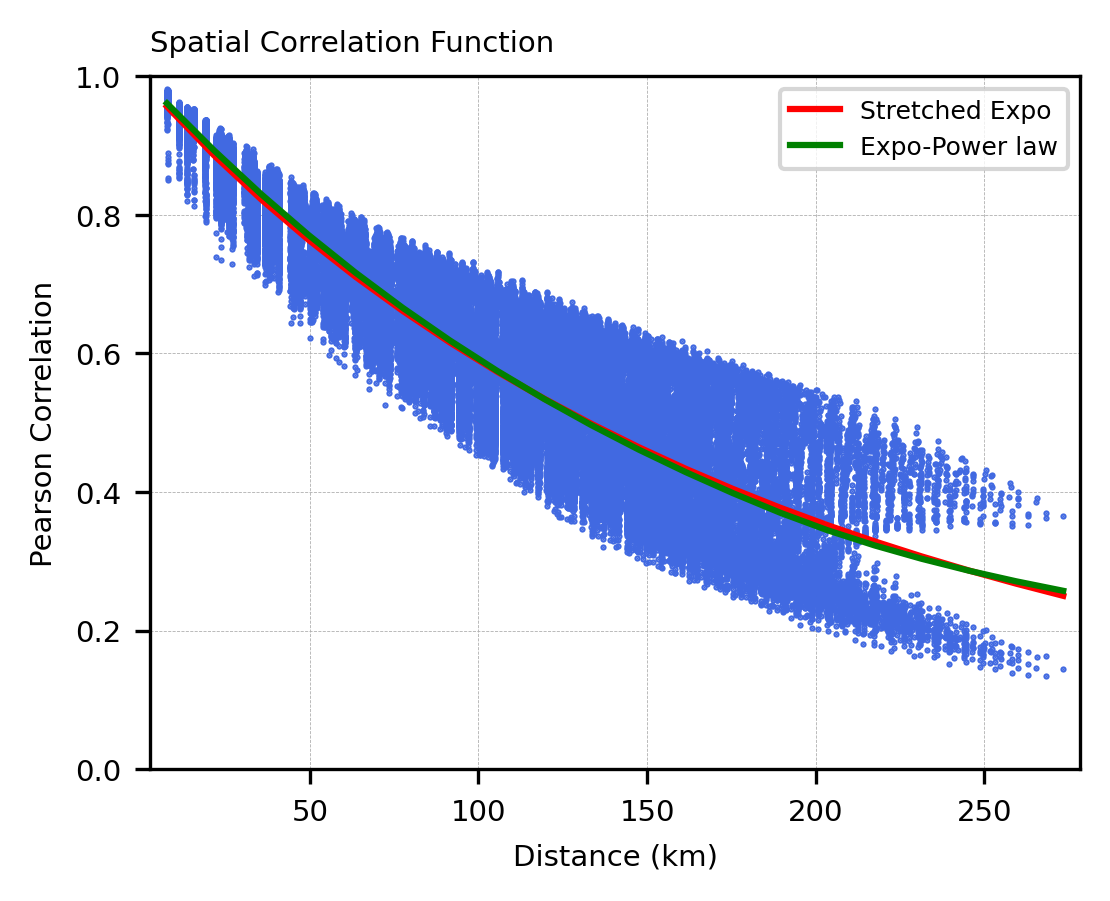

In [18]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(vdist,vcorr, '.', markersize=1, color='royalblue')
ax1.plot(xx, stretched_exp, 'r', label='Stretched Expo')
ax1.plot(xx, exp_power_law, 'g', label='Expo-Power law')

ax1.set_ylim([0, 1])
ax1.set_xlim([min(vdist)-5, max(vdist)+5])

ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)

ax1.set_title('Spatial Correlation Function', loc='left', fontsize=7)
ax1.set_xlabel('Distance (km)', fontsize=7)
ax1.set_ylabel('Pearson Correlation', fontsize=7)

plt.grid(linewidth=0.2, linestyle='--')
plt.legend(fontsize=6)

# Gamma - Reduction of Variance

* for the power-law described in Marani 2003 (default)

    acf='mar'
    
* for a stretched exponential acf (Villarini et al)

    acf='str'

In [225]:
lon_pos = lons[12]
lat_pos = lats[9]

la_center = []
lo_center = []

lo_min = []
la_min = []

lo_max = []
la_max = []

wet_fraction = []

for nn in range(8):
    lo_min_ = lon_pos - 0.05
    lo_max_ = lon_pos + 0.05 + nn*0.1
    lo_min.append(lo_min_)
    lo_max.append(lo_max_)

    la_min_ = lat_pos + 0.05
    la_max_ = lat_pos - 0.05 - nn*0.1
    la_min.append(la_min_)
    la_max.append(la_max_)
    
    lo_center.append((lo_max_+lo_min_)/2)
    la_center.append((la_max_+la_min_)/2)
    
    if nn == 0:
        wet_fraction.append(wetfrac(DATA['PRE'][:,9,12],thresh))
        print(np.round(wetfrac(DATA['PRE'][:,9,12],thresh),4))
    else:
        wet_fraction.append(np.round(wetfrac(np.mean(DATA['PRE'][:,9-nn:10,12:12+nn+1],axis=(1,2)),thresh),4))
        print(wetfrac(np.mean(DATA['PRE'][:,9-nn:10,12:12+nn+1],axis=(1,2)),thresh))

0.2996
0.30677887940973025
0.31242794558450543
0.3186534470832373
0.3308738759511183
0.3339866267004842
0.33571593267235417
0.3367535162554761


Export to ../fig/gif/integration_00.png
Export to ../fig/gif/integration_01.png
Export to ../fig/gif/integration_02.png
Export to ../fig/gif/integration_03.png
Export to ../fig/gif/integration_04.png
Export to ../fig/gif/integration_05.png
Export to ../fig/gif/integration_06.png
Export to ../fig/gif/integration_07.png


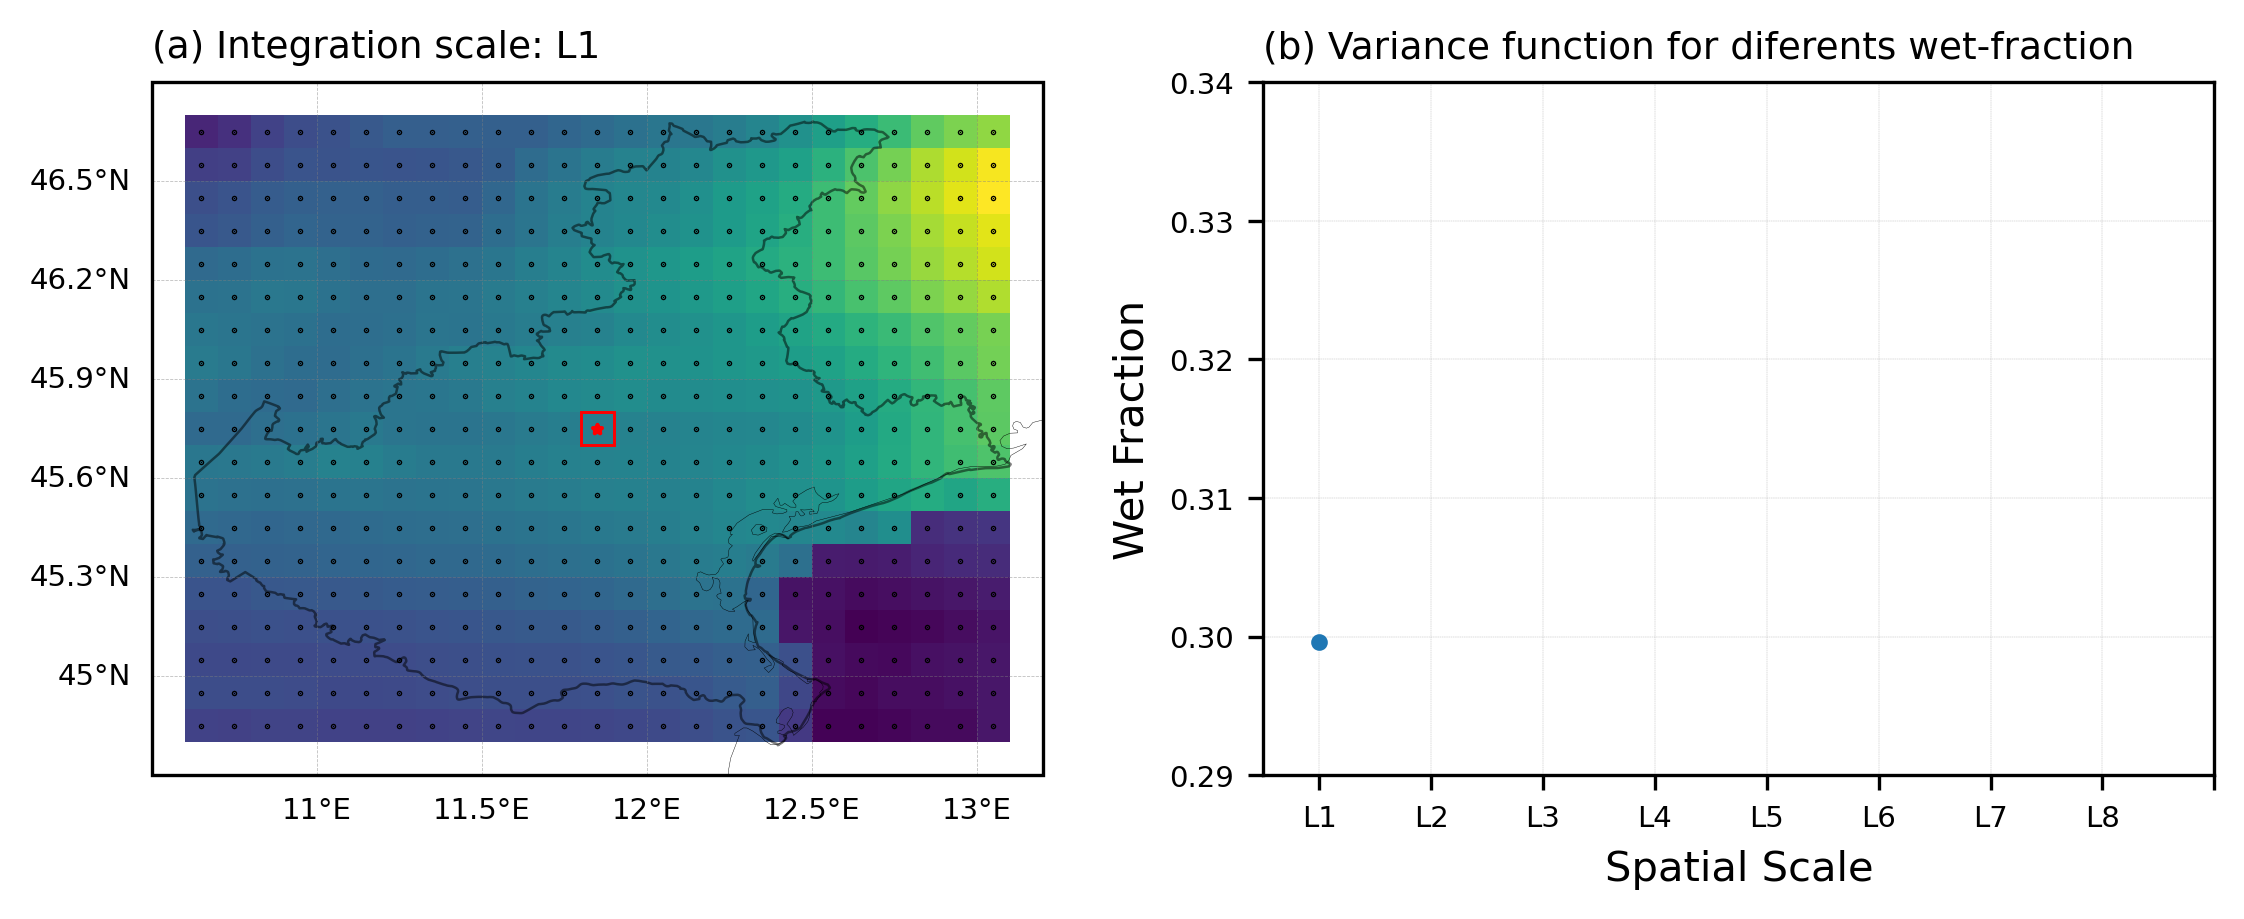

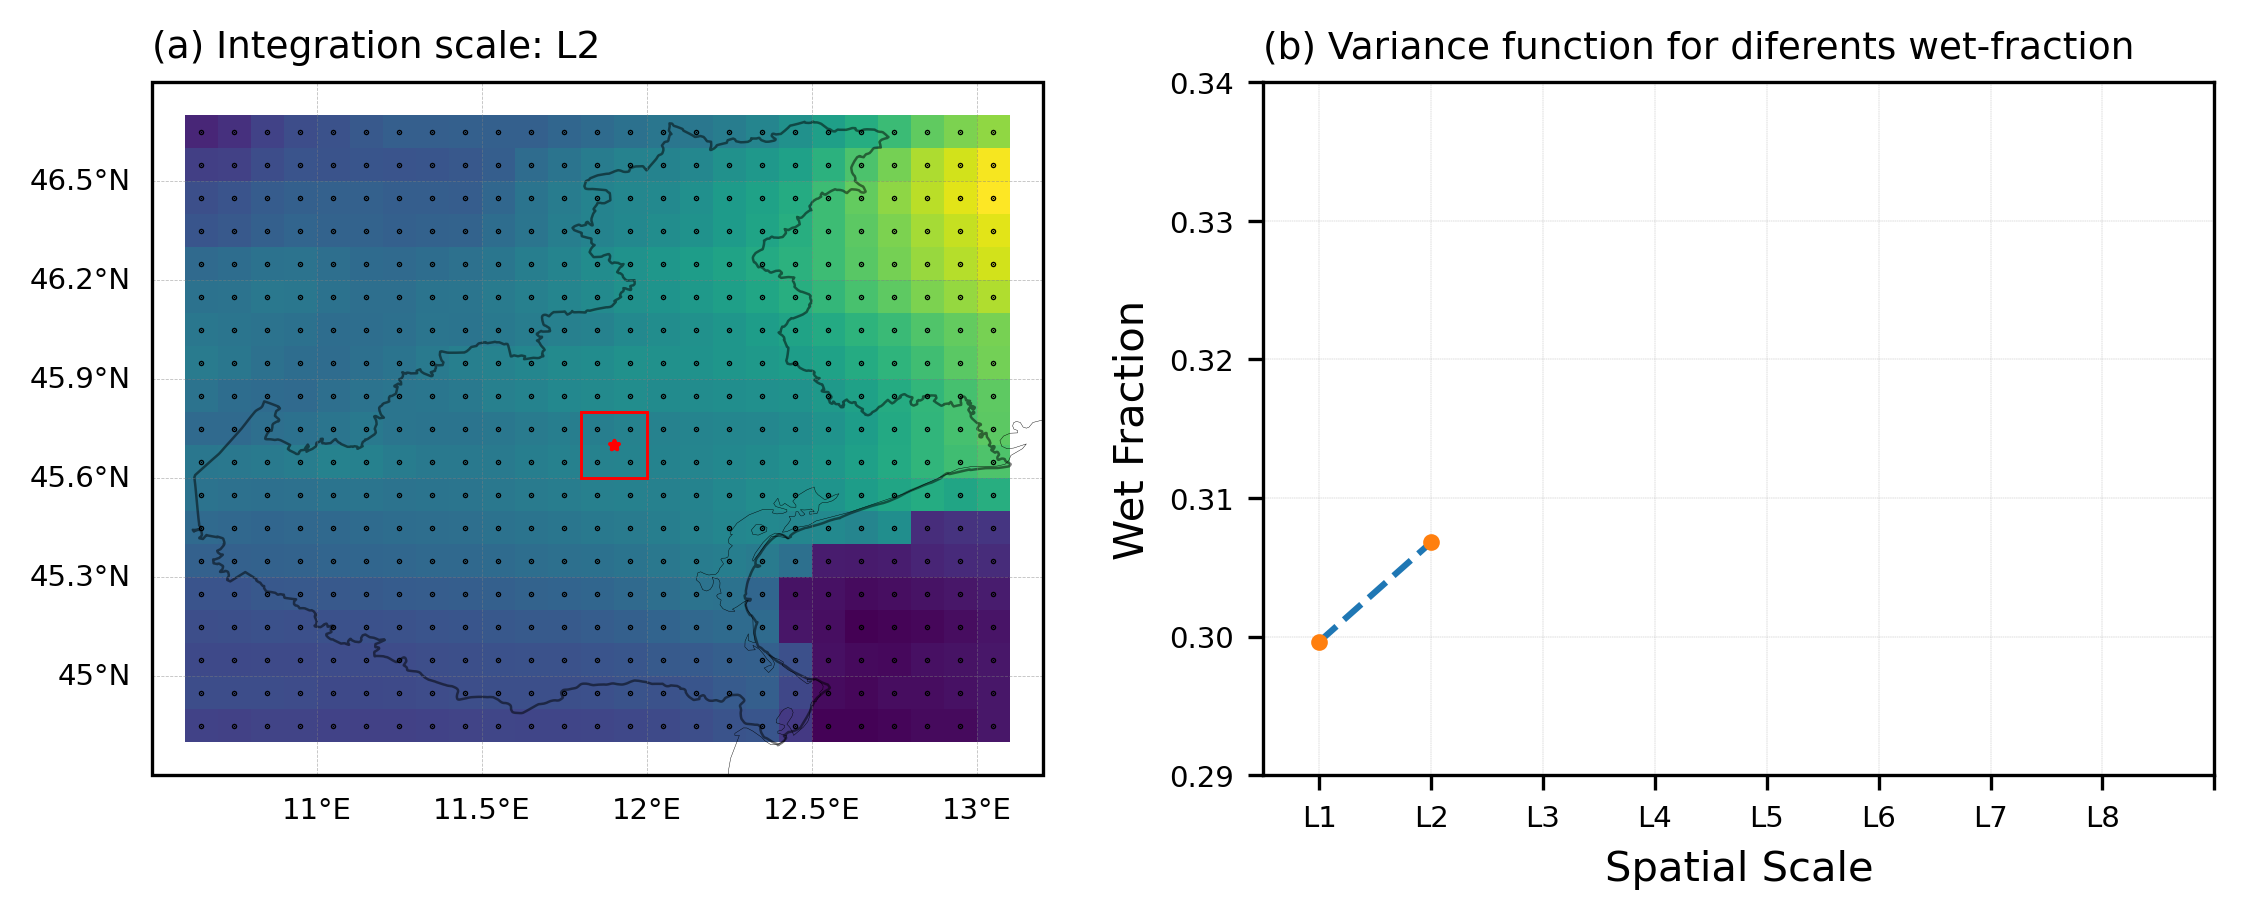

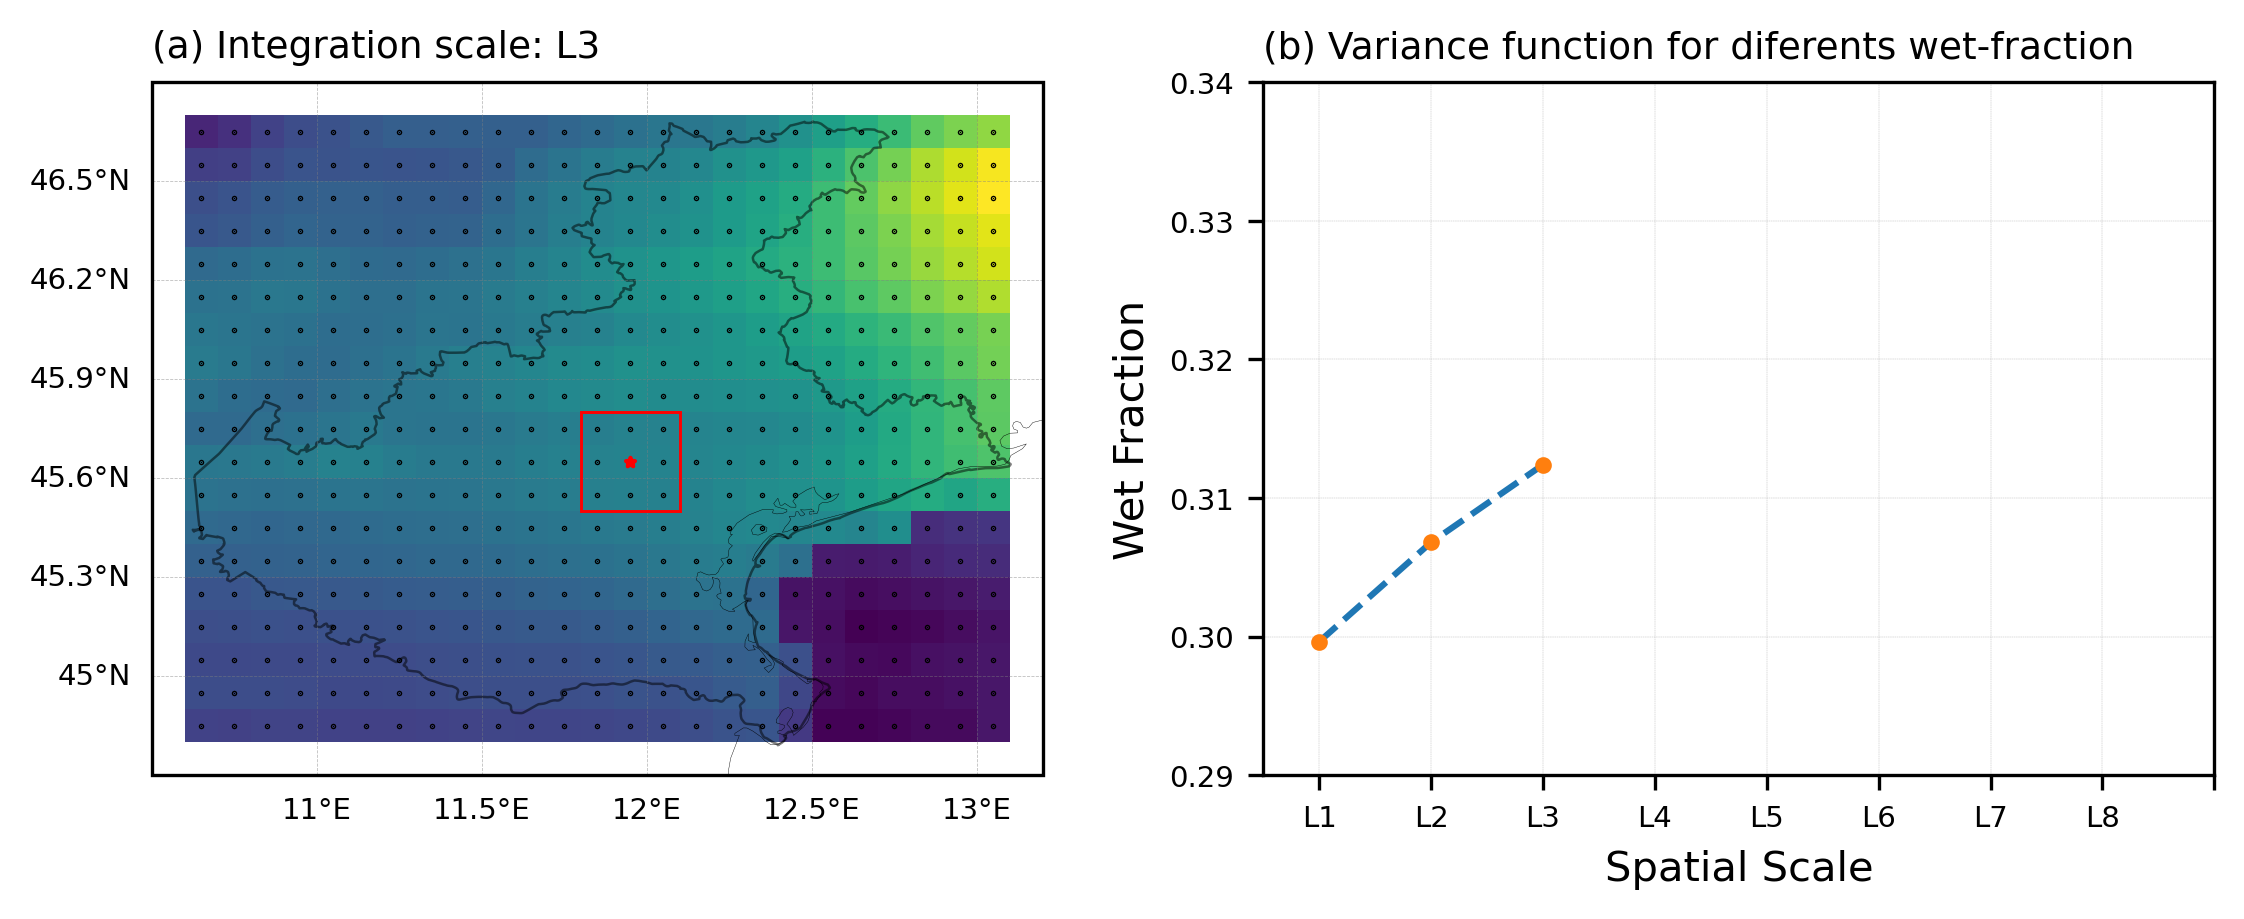

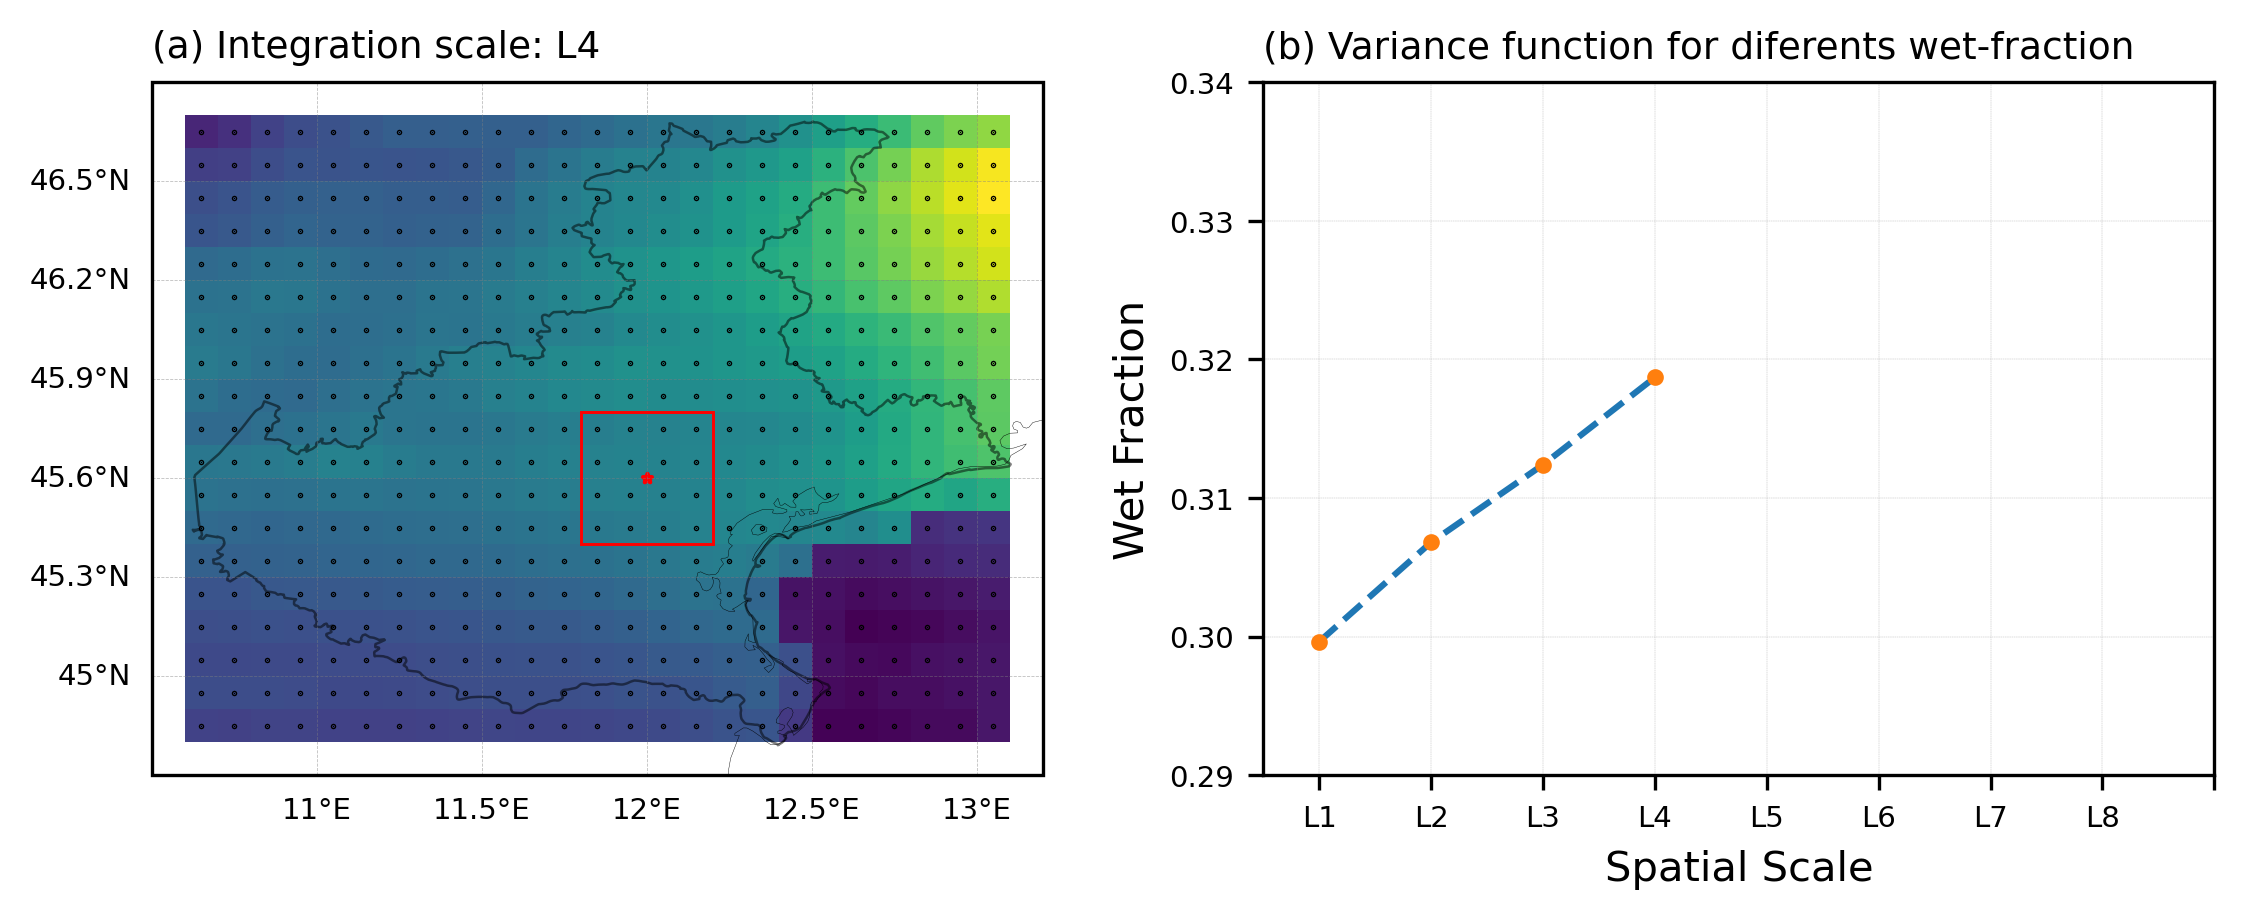

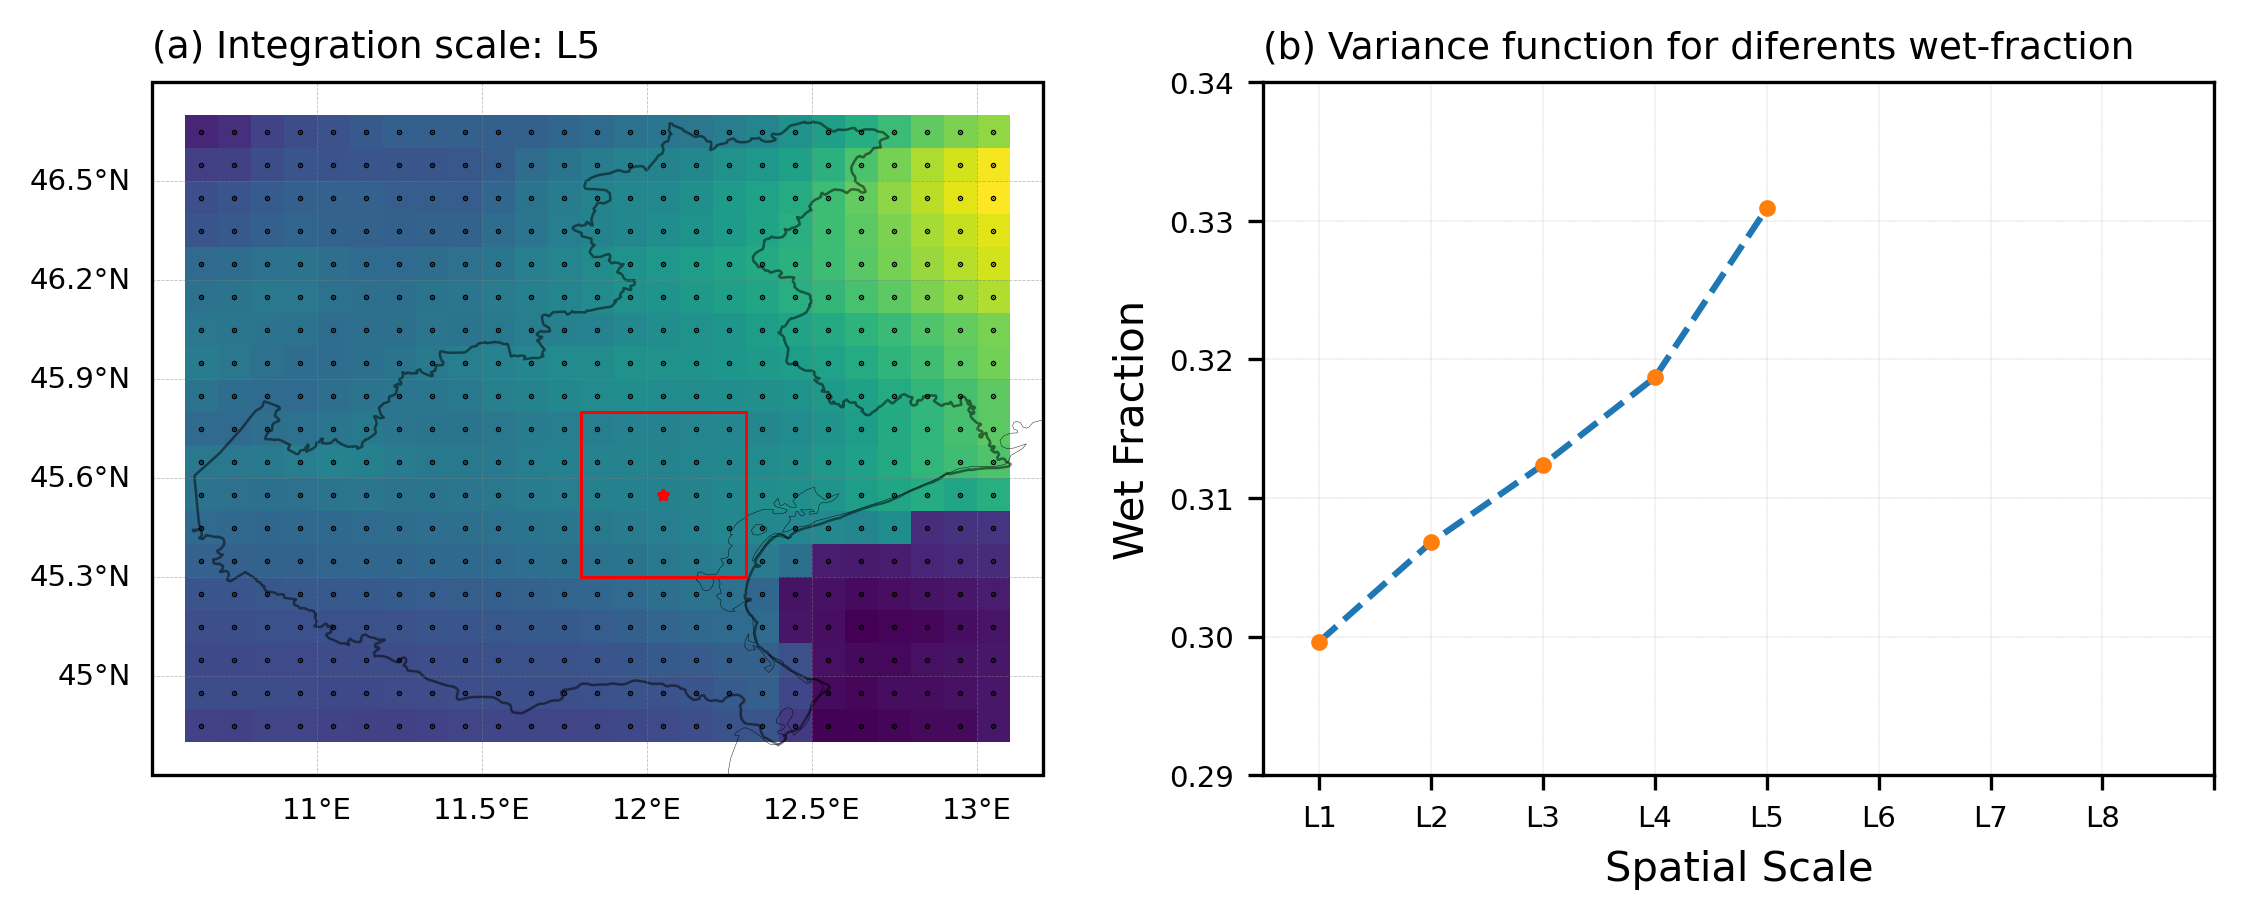

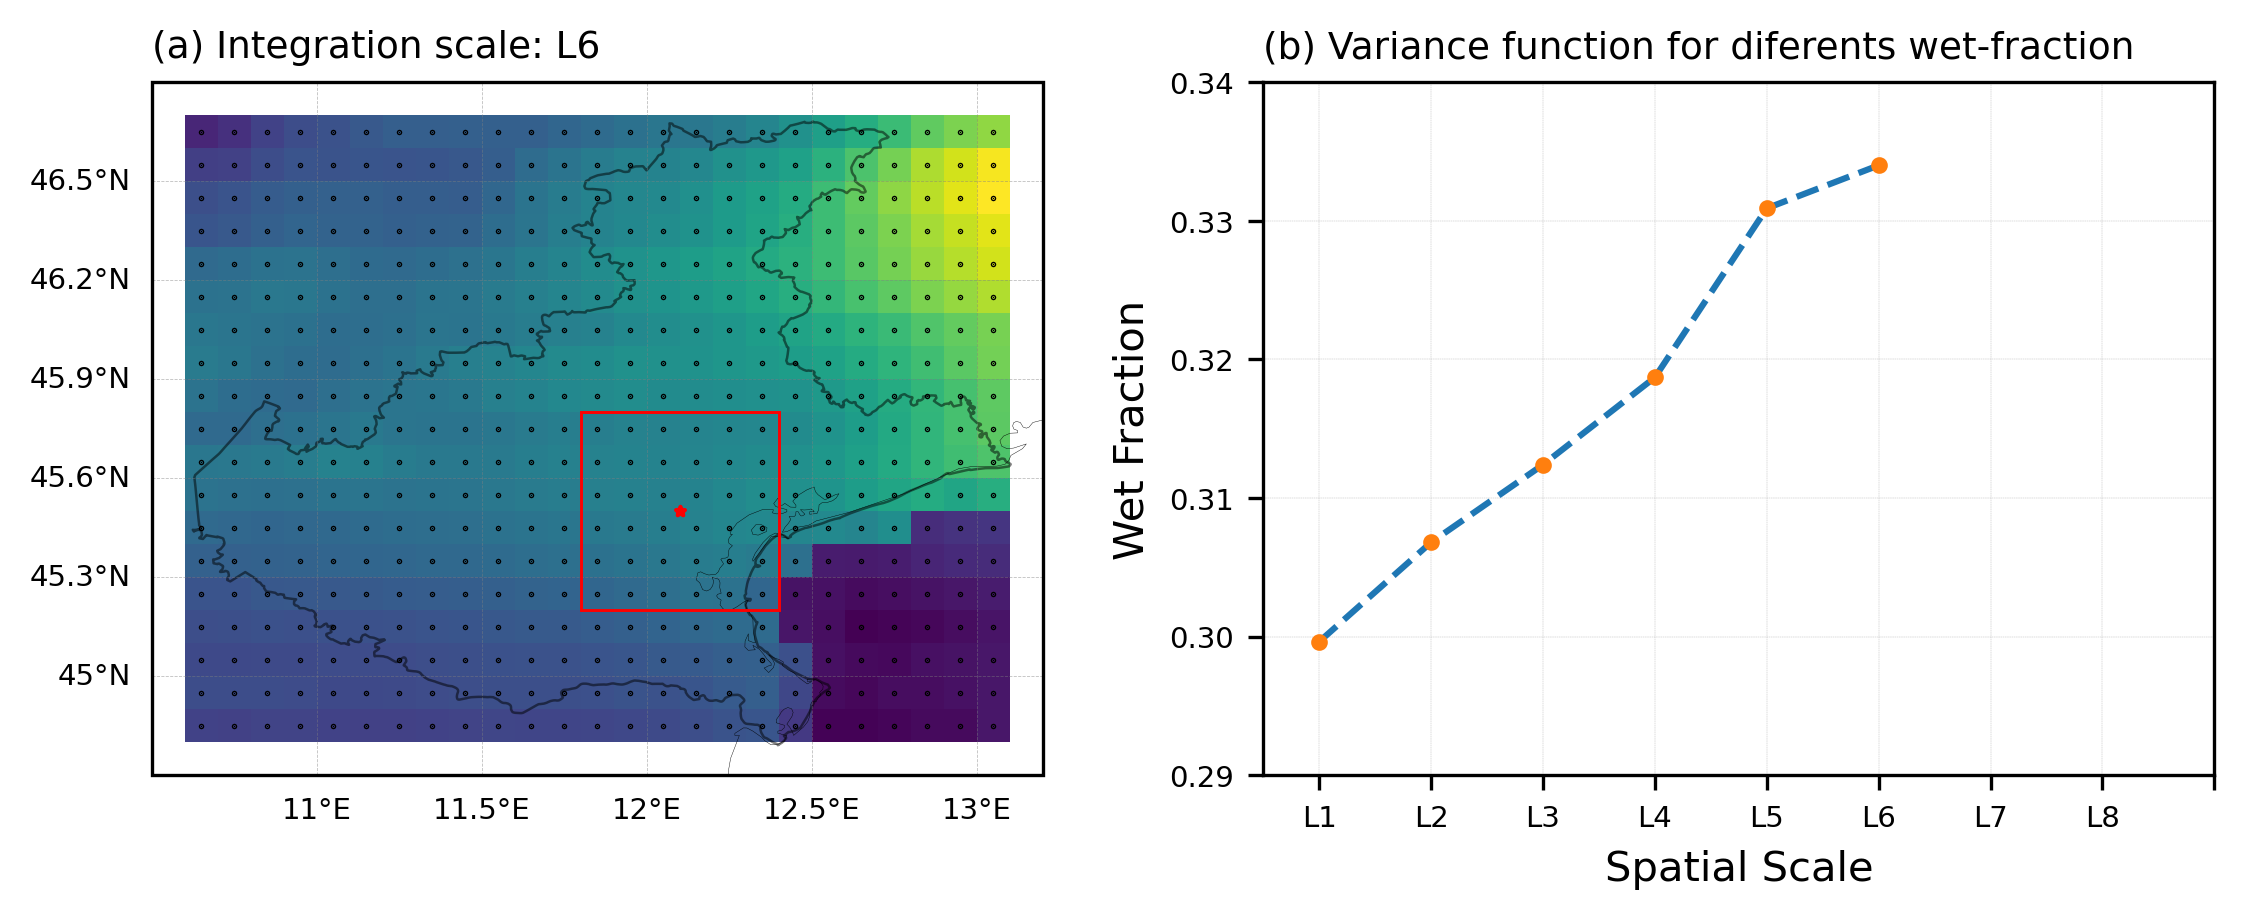

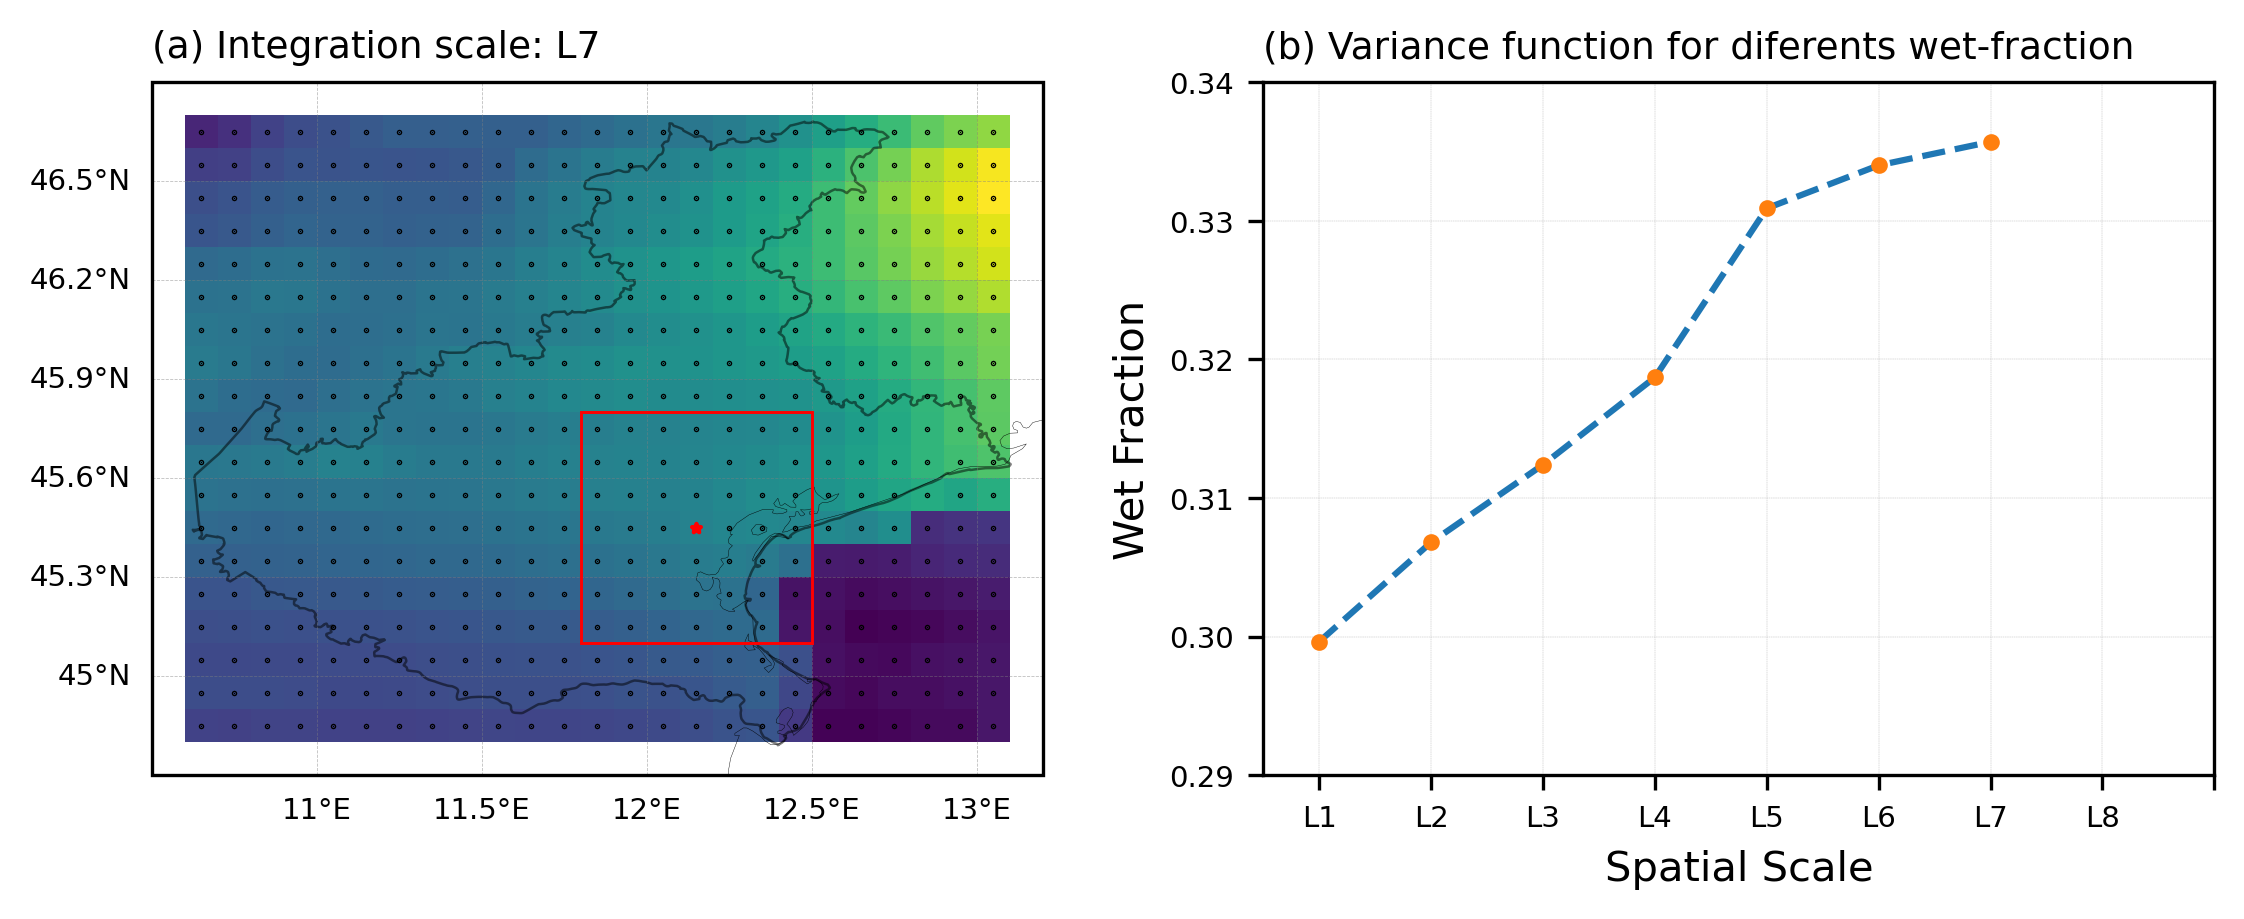

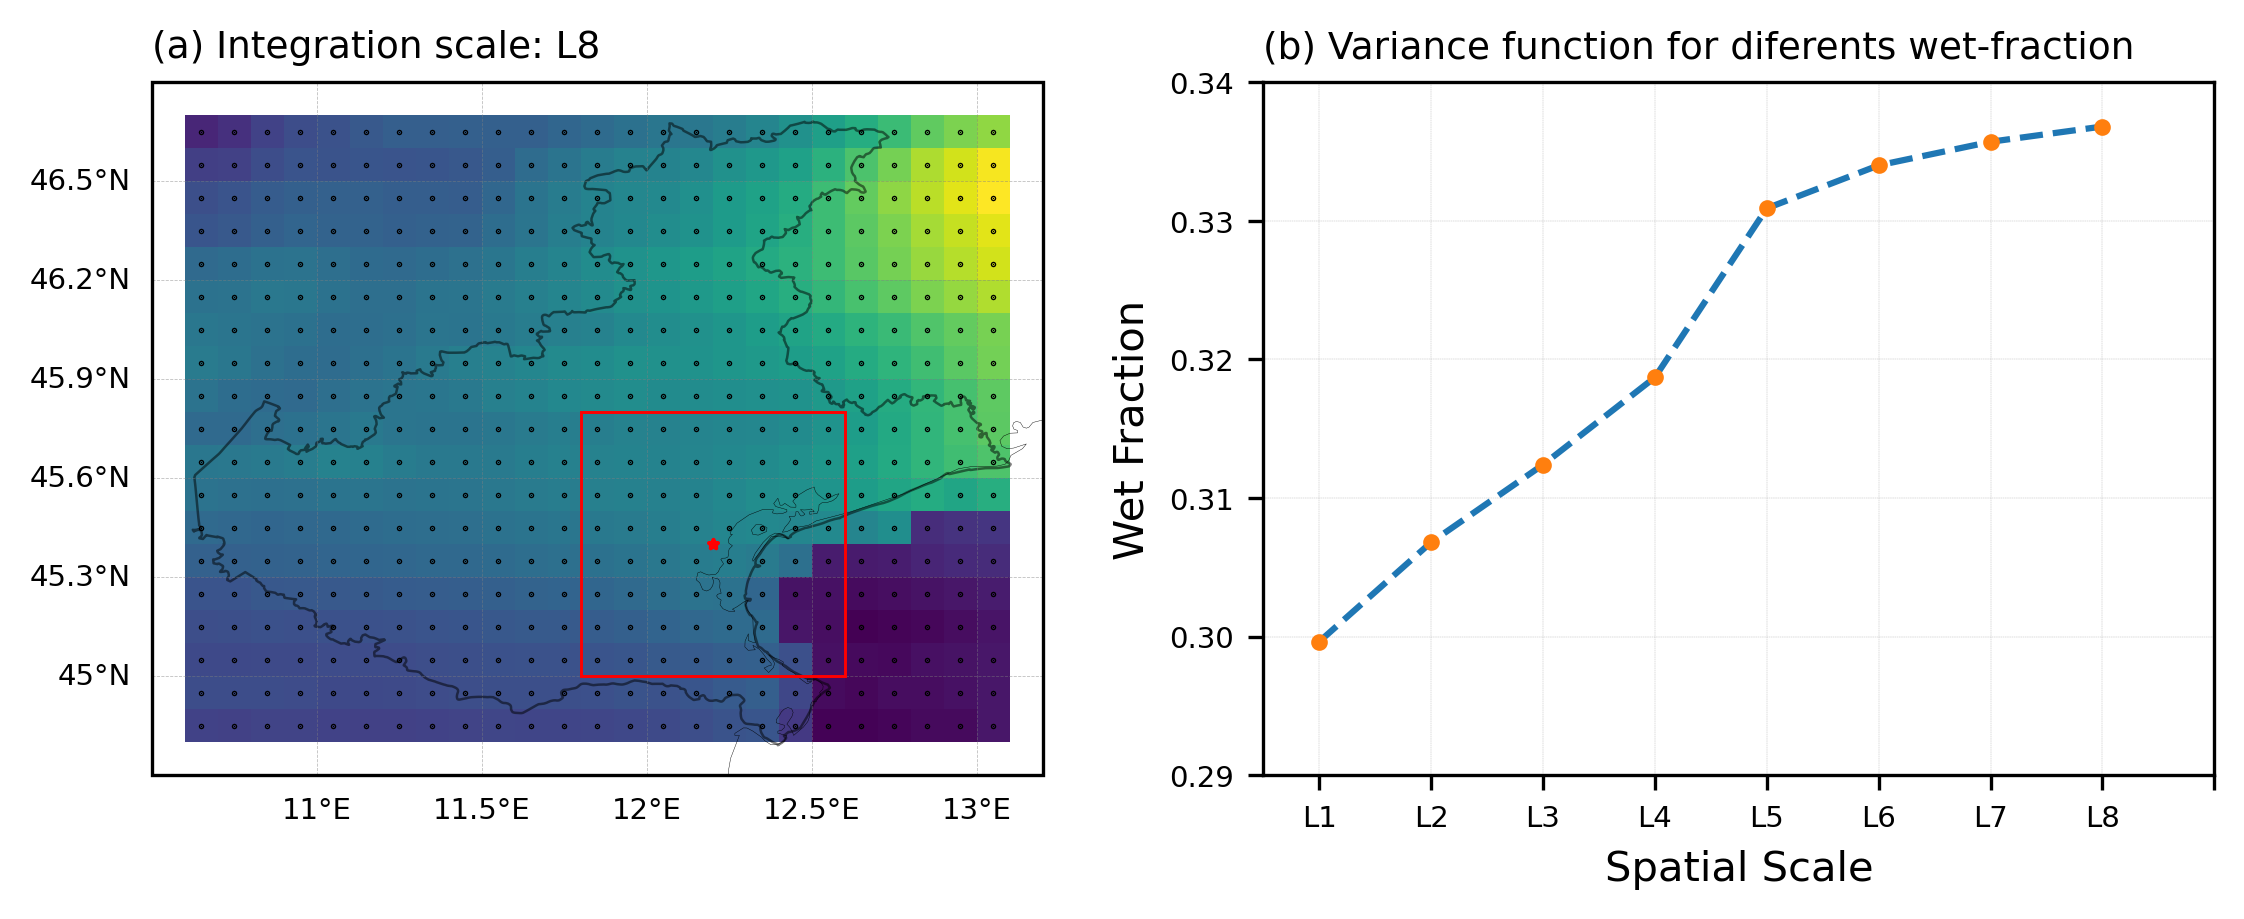

In [235]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

for nn in range(len(lo_center)):#
    
    fig = plt.figure(figsize=(9,3),dpi=300)
    gs = gridspec.GridSpec(1,2)

    # ============================================================================================================================
    ax1 = plt.subplot(gs[0, 0], projection = proj)
    ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
    ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
    # a1 = ax1.contourf(lon2d, lat2d, np.nanmean(DATA['PRE'],axis=0), cmap=cmap)
    a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(DATA['PRE'],axis=0))
    ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
    
    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    gl.xlabel_style = {'size': 7, 'color': 'k'}
    gl.ylabel_style = {'size': 7, 'color': 'k'}

    ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')
    
    ax1.scatter(lo_center[nn], la_center[nn], s=5, c='r', marker='*')
    ax1.add_patch(patches.Rectangle((lo_max[nn],la_max[nn]),
                                    lo_min[nn]-lo_max[nn],la_min[nn]-la_max[nn],
                                    linestyle='-',linewidth=0.7,edgecolor='r',facecolor='None',zorder=10))
    
    ax1.set_title(f'(a) Integration scale: L{nn+1}', fontsize=9, loc='left')
    
    # ============================================================================================================================
    L_labels = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', '']
    ax1 = plt.subplot(gs[0, 1])
    if nn == 0:
        ax1.plot(wet_fraction[0],'.')
    else:
        ax1.plot(wet_fraction[0:nn+1],'--')
        ax1.plot(wet_fraction[0:nn+1],'.')

    ax1.set_xlim(-0.5,8)
    ax1.set_ylim(0.29,0.34)
    ax1.tick_params(axis='x', labelsize=7)
    ax1.tick_params(axis='y', labelsize=7)
    ax1.set_xlabel('Spatial Scale')
    ax1.set_ylabel('Wet Fraction')
    ax1.set_title(f'(b) Variance function for diferents wet-fraction', fontsize=9, loc='left')
    ax1.set_xticks(np.arange(9))
    ax1.set_xticklabels(L_labels)
    
    ax1.grid(linewidth=0.1, linestyle='--')
    
    # ============================================================================================================================
    fig_SOM = os.path.join('..','fig','gif',f'integration_{str(nn).zfill(2)}.png')
    print(f'Export to {fig_SOM}')
    # plt.savefig(fig_SOM, facecolor='white',bbox_inches ='tight',pad_inches = 0.1)

In [19]:
# L1 = down.area_lat_long(lats[5], lons[5], dx, dy)[0]
L1 = 10 # 10 km
L0 = 0.0001 # 1 km
print(L1)

10


In [21]:
# compute variance reduction factor
fun_XY = lambda x, y: (L1 - x) * (L1 - y) * down.epl_fun(np.sqrt(x ** 2 + y ** 2), res['d0_s'], res['mu0_s'])
fun_XY0 = lambda x, y: (L0 - x) * (L0 - y) * down.epl_fun(np.sqrt(x ** 2 + y ** 2), res['d0_s'], res['mu0_s'])

In [22]:
# its 2D integral a-la Vanmarcke
int_XY, abserr   = dblquad(fun_XY,  0.0, L1,  lambda x: 0.0, lambda x: L1)
int_XY0, abserr0 = dblquad(fun_XY0, 0.0, L0, lambda x: 0.0, lambda x: L0)

gam = (L0 / L1) ** 4 * (int_XY / int_XY0)

print(f'Gamma from L1 ({L1} m) and L0 ({L0} km) is {gam}')

Gamma from L1 (10 m) and L0 (0.0001 km) is 0.974683950803194


In [23]:
L1 = 10
L0_s = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
gam_list = []

for nn in range(len(L0_s)):
    L0 = L0_s[nn]
    # compute variance reduction factor
    fun_XY = lambda x, y: (L1 - x) * (L1 - y) * down.epl_fun(np.sqrt(x ** 2 + y ** 2), res['d0_s'], res['mu0_s'])
    fun_XY0 = lambda x, y: (L0 - x) * (L0 - y) * down.epl_fun(np.sqrt(x ** 2 + y ** 2), res['d0_s'], res['mu0_s'])
    
    # its 2D integral a-la Vanmarcke
    int_XY, abserr   = dblquad(fun_XY,  0.0, L1,  lambda x: 0.0, lambda x: L1)
    int_XY0, abserr0 = dblquad(fun_XY0, 0.0, L0, lambda x: 0.0, lambda x: L0)

    gam_list.append((L0 / L1) ** 4 * (int_XY / int_XY0))

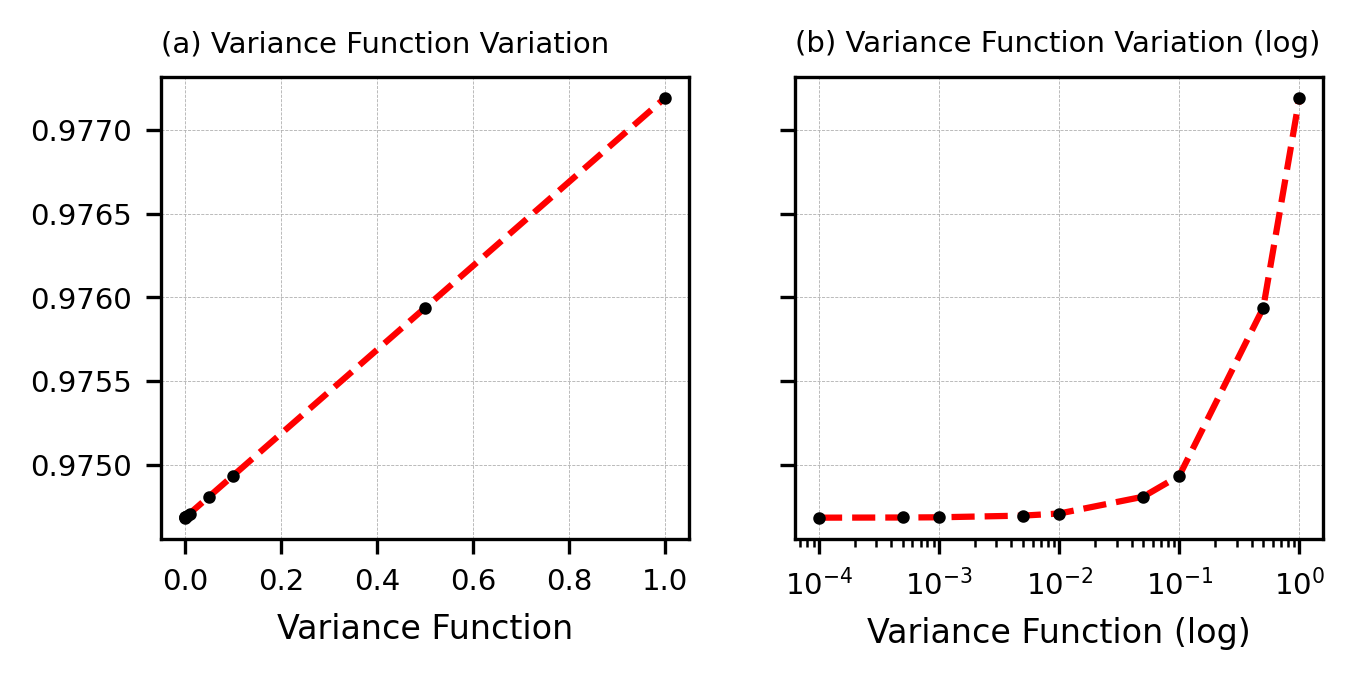

In [24]:
fig = plt.figure(figsize=(5,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ====================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(L0_s, gam_list, 'k.',markersize=4, zorder=8)
ax1.plot(L0_s, gam_list, 'r--',markersize=4)

ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)

ax1.set_xlabel('Spatial Scale', fontsize=8)
ax1.set_xlabel('Variance Function', fontsize=8)

ax1.set_title('(a) Variance Function Variation', loc='left', fontsize=7)

plt.grid(linewidth=0.2, linestyle='--')

# ====================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(L0_s, gam_list, 'k.',markersize=4, zorder=8)
ax1.plot(L0_s, gam_list, 'r--',markersize=4)

ax1.set_xscale('log')

ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)

ax1.set_xlabel('Spatial Scale', fontsize=8)
ax1.set_xlabel('Variance Function (log)', fontsize=8)
ax1.set_yticklabels([])

ax1.set_title('(b) Variance Function Variation (log)', loc='left', fontsize=7)

plt.grid(linewidth=0.2, linestyle='--')

# Beta - Estimate of the wet fraction

In [25]:
xrs0 = xr.DataArray(xrs[0:18,0:18,:], 
                coords={
                        'lon':xrs['lon'].values[0:18], 
                        'lat':xrs['lat'].values[0:18], 'time':dates},
                        dims=('lon', 'lat', 'time'))
# set negative values to NaN (missing values)
xrs = xrs0.where(xrs0 >= -0.001)

- dt: time scale of the precipitation product [HOURS] (default 3 hours)
- L1: linear spatial scale of a grid cell [km] (default is 25 km)
- target_x: subgrid spatial scale we want pwet at [km](default 0.0001 km)
- target_t: target time scale, in [HOURS] (default 24 hours)
- origin_x: linear spatial scale of origin gridded prcp [km] (default 25)
- origin_t: time scale of origin gridded pecip [HOURS] (default 24 hours)

In [26]:
thresh = 1
dt = 1
target_x = 0.0001
target_t = 2
origin_x = 100 * 0.1 # km
origin_t = 1

tmax =  12 # In hours

ninterp = 1000
cube1size = 3

In [27]:
smax = xrs0.shape[0] # Longitudes number

tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*dt
tscales = tscales[tscales < tmax + 0.001]

xscales = np.arange(1, smax+1)
ntscales = np.size(tscales)
nsscales = np.size(xscales)
pwets = np.zeros((ntscales, nsscales))

## pwets, xscales and tscales

In [28]:
for it, st in enumerate(tscales):
    
    datamat = xrs0.resample(time='{}d'.format(st)).sum(dim='time', skipna = False)

    for ix, sx in enumerate(xscales):

        if sx == 1: # pixel scale

            toskip = smax - cube1size
            if toskip % 2 == 0:
                buffer1 = toskip // 2
                buffer2 = toskip // 2
            else:
                buffer1 = toskip // 2
                buffer2 = buffer1 + 1

            if buffer2 > 0:
                aggt1 = datamat[buffer1:-buffer2, buffer1:-buffer2, :]
            else:
                aggt1 = datamat[buffer1:, buffer1:, :]

            p1 = np.zeros((aggt1.shape[0], aggt1.shape[1]))

            for x in range(aggt1.shape[0]):
                for y in range(aggt1.shape[1]):
                    # print('Hello1')
                    p1[x, y] = wetfrac(aggt1[x, y, :].dropna(
                                        dim='time', how='any'), thresh)
            pwets[it, ix] = np.mean(p1)

        elif sx == smax: # largest scale: simple average
            pwets[it, ix] = wetfrac(datamat.mean(dim=('lat', 'lon'),
                            skipna = False).dropna(dim='time', how='any'),thresh)

        else: # intermediate scales
            c1 = np.zeros(4)
            c1[0] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),thresh)
            c1[1] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),thresh)
            c1[2] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),thresh)
            c1[3] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),thresh)
            pwets[it, ix] = np.mean(c1)

In [44]:
wetfrac(xrs0[5,5,:].data,thresh)

0.2735762047498271

In [45]:
wetfrac((xrs0[5,5,:].data+xrs0[4,5,:].data+xrs0[5,4,:].data+xrs0[4,4,:].data),thresh)

0.37387595111828453

In [29]:
xscales_km = xscales*L1
ntscales = np.size(tscales)
nxscales = np.size(xscales)
tscales_int = np.linspace(np.min(tscales), np.max(tscales), ninterp)
pwmat_int = np.zeros((ninterp, nxscales))
for col in range(nxscales):
    pwmat_int[:, col] = np.interp(tscales_int, tscales, pwets[:, col])

# dxv, dtv = np.meshgrid(xscales_km, tscales_int )
pw_min = np.min(pwets)
pw_max = np.max(pwets)
mypw = np.linspace(pw_min, pw_max, ninterp)

myU = np.zeros(ninterp)   # initialize linear slope
myX0 = np.zeros(ninterp)  # initialize linear intercept
myindices = np.zeros((ninterp, nxscales), dtype = int)
# tvec =  np.zeros((ninterp, nxscales))

In [30]:
xscales_km

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180])

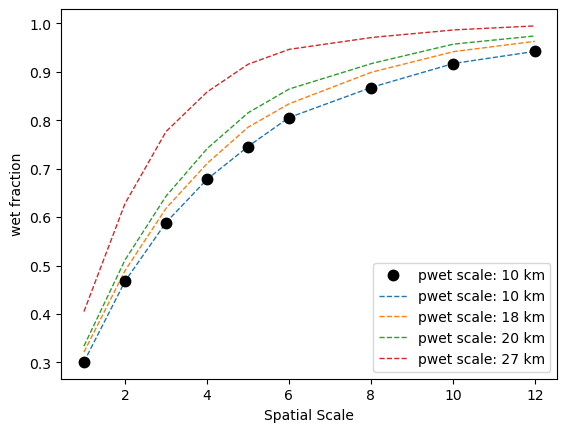

In [31]:
col_2 = 0

plt.plot(tscales, pwets[:, col_2], '.k', markersize=15, linewidth=3, label=f'pwet scale: {xscales_km[col_2]} km',zorder = 10)

plt.plot(tscales_int, pwmat_int[:, col_2], '--', linewidth=1, label=f'pwet scale: {xscales_km[col_2]} km')
plt.plot(tscales_int, pwmat_int[:, col_2+8], '--', linewidth=1, label=f'pwet scale: {xscales_km[col_2]+8} km')
plt.plot(tscales_int, pwmat_int[:, col_2+10], '--', linewidth=1, label=f'pwet scale: {xscales_km[col_2]+10} km')
plt.plot(tscales_int, pwmat_int[:, col_2+17], '--', linewidth=1, label=f'pwet scale: {xscales_km[col_2]+17} km')

plt.xlabel('Spatial Scale')
plt.ylabel('wet fraction')

plt.legend()

In [32]:
for ii in range(ninterp):
    Tvec = np.zeros(nxscales)
    for jj in range(nxscales):
        myindices[ii,jj] = np.argmin(np.abs(pwmat_int[:, jj] - mypw[ii]))
        # tvec[ii,jj] = tscales_int[myindices[ii,jj]]
        Tvec[jj] = tscales_int[myindices[ii,jj]]
    res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
    myU[ii] = res[0]
    myX0[ii] = res[1]

/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly conditioned
  res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly conditioned
  res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly conditioned
  res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly conditioned
  res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly conditioned
  res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly conditioned
  res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly conditioned
  res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
/tmp/ipykernel_4482/1015750053.py:7: RankWarning: Polyfit may be poorly cond

In [33]:
# first remove timescales where the line goes out of bounds
min_index = myindices.min(axis=1)
max_index = myindices.max(axis=1)
col_to_keep = np.logical_and(min_index > 0, max_index < ninterp-1)
mypw2 = mypw[col_to_keep]
U = myU[col_to_keep]
X0 = myX0[col_to_keep]

# best_index = this is the index of the pwet such that
# the line extrapolated to the gauge spatial scale
# matches the requested time scale
dthat = (target_x - X0) / U # compute time scale that would give me pwet
deltat = np.abs(dthat - target_t)
opt_deltat = np.min(deltat)
max_dt = 0.5 # half hour accuracy should suffice?
# set a TOLL value to check we are not too far away from the real deltat
if opt_deltat > max_dt:
    print('Taylor_Beta WARNING: not enough accuracy!')
    print('the time resolution of the coarse data might not be enough!')
    print('or try to increase the value of interp')
best_index = np.argmin(deltat)  # best prediction of 24 hour interval
pwet_target = mypw2[best_index]

# compute pwet at the original scale:
# this is ok if origin_x is one of the points where pwet was computed
# if not, add an interpolation in the x direction!
pos_xmin = np.argmin(np.abs(origin_x - xscales_km))
pos_tmin = np.argmin(np.abs(origin_t - tscales_int))
pwet_origin = pwmat_int[pos_tmin, pos_xmin]
beta = pwet_origin / pwet_target
beta

0.637183949419008

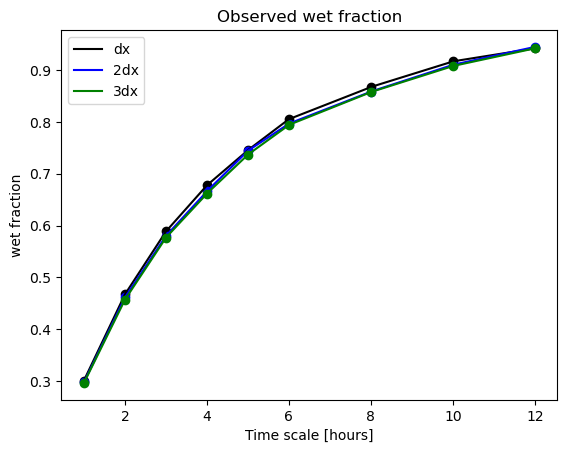

In [34]:
plt.plot(tscales, pwets[:,0], 'ok')
plt.plot(tscales, pwets[:,1], 'ob')
plt.plot(tscales_int, pwmat_int[:,0], '-k', label = 'dx')
plt.plot(tscales_int, pwmat_int[:,1], '-b', label = '2dx')
if nxscales > 2:
    plt.plot(tscales, pwets[:,2], 'og')
    plt.plot(tscales_int, pwmat_int[:,2], '-g', label = '3dx')
plt.xlabel('Time scale [hours]')
plt.ylabel('wet fraction')
plt.title('Observed wet fraction')
plt.legend()

(0.0, 12.5)

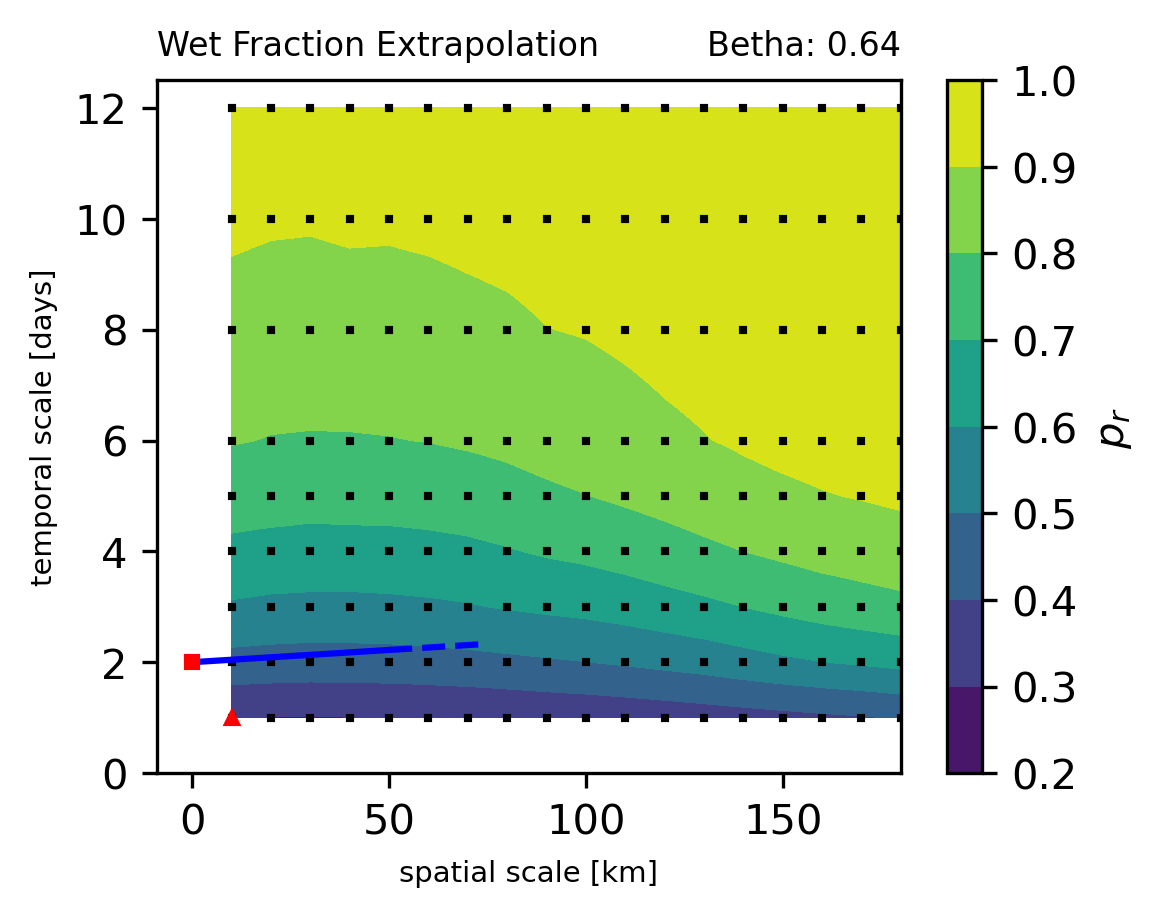

In [35]:
xxx1 = np.linspace(0, 50, 10)
xxx2 = np.linspace(50, 75, 10)

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ====================================================================
ax1 = plt.subplot(gs[0, 0])
a1 = ax1.contourf(xscales_km, tscales_int, pwmat_int)
cbar = plt.colorbar(a1)
cbar.set_label(r'$p_r$')

for ii in range(nxscales):
    for jj in range(ntscales):
        ax1.plot(xscales_km[ii], tscales[jj], 'sk', markersize=1)

ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b')
ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b')

ax1.plot(target_x, target_t, 'sr', markersize=3)
ax1.plot(origin_x, origin_t, '^r', markersize=3)

ax1.set_xlabel('spatial scale [km]', fontsize=7)
ax1.set_ylabel('temporal scale [days]', fontsize=7)
ax1.set_title('Wet Fraction Extrapolation', fontsize=8, loc='left')
ax1.set_title(f'Betha: {np.round(beta,2)}', fontsize=8, loc='right')

ax1.set_ylim(0, 12.5)